## Assignment 5

###  Question 2.4 - 
**Add label-noise to the training data set and train the two-layer model. To make mislabeled data you can simply shuffle some of the labels. For example, if you want to make 10 percent of the data mislabeled, you can permute/shuffle 10% of the labels. Evaluate the performance of the network with different rates of label noise (10%, 25%, 50%, 75%, 100%) applied. Illustrate your result in a plot. Explain the performance of your network with %100 noise, specifically the difference between the training and test error.**

#### Adding 10% noise

In [1]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)
acc =[]

def my_cnn_model_fn(features, labels, mode):
      """Model function for CNN."""
      # Input Layer
      # Reshape X to 4-D tensor: [batch_size, width, height, channels]
      # MNIST images are 28x28 pixels, and have one color channel
      input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

      # Convolutional Layer #1
      # Computes 32 features using a 5x5 filter with ReLU activation.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 28, 28, 1]
      # Output Tensor Shape: [batch_size, 28, 28, 32]
      conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #1
      # First max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 28, 28, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 32]
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2
      # Computes 64 features using a 5x5 filter.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 14, 14, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 64]
      conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #2
      # Second max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 14, 14, 64]
      # Output Tensor Shape: [batch_size, 7, 7, 64]
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Flatten tensor into a batch of vectors
      # Input Tensor Shape: [batch_size, 7, 7, 64]
      # Output Tensor Shape: [batch_size, 7 * 7 * 64]
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

      # Dense Layer
      # Densely connected layer with 1024 neurons
      # Input Tensor Shape: [batch_size, 7 * 7 * 64]
      # Output Tensor Shape: [batch_size, 1024]
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

      # Add dropout operation; 0.6 probability that element will be kept
      dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

      # Logits layer
      # Input Tensor Shape: [batch_size, 1024]
      # Output Tensor Shape: [batch_size, 10]
      logits = tf.layers.dense(inputs=dropout, units= num_classes)

      predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }
      if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

     #  Add evaluation metrics (for EVAL mode)
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

#------------------------------------------------------------------------------------------------------
#                                Adding 10% noise
#------------------------------------------------------------------------------------------------------
size_noise_label = int(0.1* len(train_labels))
noise_label = np.random.choice(len(train_labels),size = size_noise_label,replace=False)
train_noise_label = train_labels[noise_label]
np.random.shuffle(train_noise_label)
train_labels[noise_label] = train_noise_label

indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=10,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=10000)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=10,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('')
print('')
print('The accuracy for cnn model with 10% percent noise: '+str(eval_results['accuracy']*100)+'%')
acc.append(eval_results['accuracy']*100)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_is_chief': True, '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D807B0B7B8>, '_save_checkpoints_secs': 600, '_service': None, '_model_dir': 'C:\\Users\\dalal\\AppData\\Local\\Temp\\tmpimbh2fkh', '_session_config': None, '_num_worker_replicas': 1, '_master': '', '_task_type': 'worker'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\dalal\AppData\Local\Temp\tmpimbh2fkh\model.ckpt.
INFO:tensorflow:loss = 2.3127534, step =

INFO:tensorflow:global_step/sec: 25.8955
INFO:tensorflow:loss = 0.546729, step = 7301 (3.862 sec)
INFO:tensorflow:global_step/sec: 26.36
INFO:tensorflow:loss = 1.0522172, step = 7401 (3.794 sec)
INFO:tensorflow:global_step/sec: 26.3478
INFO:tensorflow:loss = 0.7414449, step = 7501 (3.795 sec)
INFO:tensorflow:global_step/sec: 26.1204
INFO:tensorflow:loss = 1.3533013, step = 7601 (3.828 sec)
INFO:tensorflow:global_step/sec: 25.7568
INFO:tensorflow:loss = 0.7124368, step = 7701 (3.882 sec)
INFO:tensorflow:global_step/sec: 25.3233
INFO:tensorflow:loss = 0.7233072, step = 7801 (3.951 sec)
INFO:tensorflow:global_step/sec: 25.3155
INFO:tensorflow:loss = 0.4077363, step = 7901 (3.949 sec)
INFO:tensorflow:global_step/sec: 24.8593
INFO:tensorflow:loss = 0.35451382, step = 8001 (4.023 sec)
INFO:tensorflow:global_step/sec: 25.0408
INFO:tensorflow:loss = 0.3008295, step = 8101 (3.993 sec)
INFO:tensorflow:global_step/sec: 24.909
INFO:tensorflow:loss = 0.2568516, step = 8201 (4.015 sec)
INFO:tensorfl

#### Adding 25% noise

In [2]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
      """Model function for CNN."""
      # Input Layer
      # Reshape X to 4-D tensor: [batch_size, width, height, channels]
      # MNIST images are 28x28 pixels, and have one color channel
      input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

      # Convolutional Layer #1
      # Computes 32 features using a 5x5 filter with ReLU activation.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 28, 28, 1]
      # Output Tensor Shape: [batch_size, 28, 28, 32]
      conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #1
      # First max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 28, 28, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 32]
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2
      # Computes 64 features using a 5x5 filter.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 14, 14, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 64]
      conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #2
      # Second max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 14, 14, 64]
      # Output Tensor Shape: [batch_size, 7, 7, 64]
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Flatten tensor into a batch of vectors
      # Input Tensor Shape: [batch_size, 7, 7, 64]
      # Output Tensor Shape: [batch_size, 7 * 7 * 64]
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

      # Dense Layer
      # Densely connected layer with 1024 neurons
      # Input Tensor Shape: [batch_size, 7 * 7 * 64]
      # Output Tensor Shape: [batch_size, 1024]
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

      # Add dropout operation; 0.6 probability that element will be kept
      dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

      # Logits layer
      # Input Tensor Shape: [batch_size, 1024]
      # Output Tensor Shape: [batch_size, 10]
      logits = tf.layers.dense(inputs=dropout, units= num_classes)

      predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }
      if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

     #  Add evaluation metrics (for EVAL mode)
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

#------------------------------------------------------------------------------------------------------
#                                Adding 25% noise
#------------------------------------------------------------------------------------------------------
size_noise_label = int(0.25* len(train_labels))
noise_label = np.random.choice(len(train_labels),size = size_noise_label,replace=False)
train_noise_label = train_labels[noise_label]
np.random.shuffle(train_noise_label)
train_labels[noise_label] = train_noise_label
#------------------------------------------------------------------------------------------------------

indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=10,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=10000)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=10,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('')
print('')
print('The accuracy for cnn model with 25% percent noise: '+str(eval_results['accuracy']*100)+'%')
acc.append(eval_results['accuracy']*100)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_is_chief': True, '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D809980978>, '_save_checkpoints_secs': 600, '_service': None, '_model_dir': 'C:\\Users\\dalal\\AppData\\Local\\Temp\\tmpp99b3zog', '_session_config': None, '_num_worker_replicas': 1, '_master': '', '_task_type': 'worker'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\dalal\AppData\Local\Temp\tmpp99b3zog\model.ckpt.
INFO:tensorflow:loss = 2.272159, step = 

INFO:tensorflow:global_step/sec: 26.3193
INFO:tensorflow:loss = 1.1220269, step = 7301 (3.800 sec)
INFO:tensorflow:global_step/sec: 26.1633
INFO:tensorflow:loss = 0.99292964, step = 7401 (3.822 sec)
INFO:tensorflow:global_step/sec: 25.9844
INFO:tensorflow:loss = 0.72877604, step = 7501 (3.849 sec)
INFO:tensorflow:global_step/sec: 25.9178
INFO:tensorflow:loss = 1.5090032, step = 7601 (3.857 sec)
INFO:tensorflow:global_step/sec: 26.0093
INFO:tensorflow:loss = 1.543918, step = 7701 (3.845 sec)
INFO:tensorflow:global_step/sec: 25.7529
INFO:tensorflow:loss = 1.1836331, step = 7801 (3.884 sec)
INFO:tensorflow:global_step/sec: 25.5541
INFO:tensorflow:loss = 1.830684, step = 7901 (3.913 sec)
INFO:tensorflow:global_step/sec: 25.7675
INFO:tensorflow:loss = 1.0877903, step = 8001 (3.881 sec)
INFO:tensorflow:global_step/sec: 25.6997
INFO:tensorflow:loss = 1.2346796, step = 8101 (3.890 sec)
INFO:tensorflow:global_step/sec: 25.8581
INFO:tensorflow:loss = 1.3021696, step = 8201 (3.867 sec)
INFO:tenso

#### Added 50% noise

In [3]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
      """Model function for CNN."""
      # Input Layer
      # Reshape X to 4-D tensor: [batch_size, width, height, channels]
      # MNIST images are 28x28 pixels, and have one color channel
      input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

      # Convolutional Layer #1
      # Computes 32 features using a 5x5 filter with ReLU activation.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 28, 28, 1]
      # Output Tensor Shape: [batch_size, 28, 28, 32]
      conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #1
      # First max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 28, 28, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 32]
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2
      # Computes 64 features using a 5x5 filter.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 14, 14, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 64]
      conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #2
      # Second max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 14, 14, 64]
      # Output Tensor Shape: [batch_size, 7, 7, 64]
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Flatten tensor into a batch of vectors
      # Input Tensor Shape: [batch_size, 7, 7, 64]
      # Output Tensor Shape: [batch_size, 7 * 7 * 64]
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

      # Dense Layer
      # Densely connected layer with 1024 neurons
      # Input Tensor Shape: [batch_size, 7 * 7 * 64]
      # Output Tensor Shape: [batch_size, 1024]
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

      # Add dropout operation; 0.6 probability that element will be kept
      dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

      # Logits layer
      # Input Tensor Shape: [batch_size, 1024]
      # Output Tensor Shape: [batch_size, 10]
      logits = tf.layers.dense(inputs=dropout, units= num_classes)

      predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }
      if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

     #  Add evaluation metrics (for EVAL mode)
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

#------------------------------------------------------------------------------------------------------
#                                Adding 50% noise
#------------------------------------------------------------------------------------------------------
size_noise_label = int(0.5* len(train_labels))
noise_label = np.random.choice(len(train_labels),size = size_noise_label,replace=False)
train_noise_label = train_labels[noise_label]
np.random.shuffle(train_noise_label)
train_labels[noise_label] = train_noise_label

indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=10,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=10000)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=10,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('')
print('')
print('The accuracy for cnn model with 50% percent noise: '+str(eval_results['accuracy']*100)+'%')
acc.append(eval_results['accuracy']*100)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_is_chief': True, '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D809AA4080>, '_save_checkpoints_secs': 600, '_service': None, '_model_dir': 'C:\\Users\\dalal\\AppData\\Local\\Temp\\tmpir21itga', '_session_config': None, '_num_worker_replicas': 1, '_master': '', '_task_type': 'worker'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\dalal\AppData\Local\Temp\tmpir21itga\model.ckpt.
INFO:tensorflow:loss = 2.2800984, step =

INFO:tensorflow:global_step/sec: 26.4583
INFO:tensorflow:loss = 1.436131, step = 7301 (3.780 sec)
INFO:tensorflow:global_step/sec: 26.4508
INFO:tensorflow:loss = 1.5640347, step = 7401 (3.780 sec)
INFO:tensorflow:global_step/sec: 26.4085
INFO:tensorflow:loss = 1.1637453, step = 7501 (3.787 sec)
INFO:tensorflow:global_step/sec: 26.3979
INFO:tensorflow:loss = 1.7271674, step = 7601 (3.788 sec)
INFO:tensorflow:global_step/sec: 26.5047
INFO:tensorflow:loss = 1.9331312, step = 7701 (3.772 sec)
INFO:tensorflow:global_step/sec: 26.5295
INFO:tensorflow:loss = 2.35938, step = 7801 (3.769 sec)
INFO:tensorflow:global_step/sec: 26.5377
INFO:tensorflow:loss = 1.6512057, step = 7901 (3.768 sec)
INFO:tensorflow:global_step/sec: 26.8505
INFO:tensorflow:loss = 1.5347369, step = 8001 (3.724 sec)
INFO:tensorflow:global_step/sec: 26.9108
INFO:tensorflow:loss = 2.1305926, step = 8101 (3.716 sec)
INFO:tensorflow:global_step/sec: 27.7517
INFO:tensorflow:loss = 1.5429423, step = 8201 (3.603 sec)
INFO:tensorfl

#### Adding 75%noise

In [4]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
      """Model function for CNN."""
      # Input Layer
      # Reshape X to 4-D tensor: [batch_size, width, height, channels]
      # MNIST images are 28x28 pixels, and have one color channel
      input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

      # Convolutional Layer #1
      # Computes 32 features using a 5x5 filter with ReLU activation.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 28, 28, 1]
      # Output Tensor Shape: [batch_size, 28, 28, 32]
      conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #1
      # First max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 28, 28, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 32]
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2
      # Computes 64 features using a 5x5 filter.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 14, 14, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 64]
      conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #2
      # Second max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 14, 14, 64]
      # Output Tensor Shape: [batch_size, 7, 7, 64]
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Flatten tensor into a batch of vectors
      # Input Tensor Shape: [batch_size, 7, 7, 64]
      # Output Tensor Shape: [batch_size, 7 * 7 * 64]
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

      # Dense Layer
      # Densely connected layer with 1024 neurons
      # Input Tensor Shape: [batch_size, 7 * 7 * 64]
      # Output Tensor Shape: [batch_size, 1024]
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

      # Add dropout operation; 0.6 probability that element will be kept
      dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

      # Logits layer
      # Input Tensor Shape: [batch_size, 1024]
      # Output Tensor Shape: [batch_size, 10]
      logits = tf.layers.dense(inputs=dropout, units= num_classes)

      predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }
      if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

     #  Add evaluation metrics (for EVAL mode)
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

#------------------------------------------------------------------------------------------------------
#                                Adding 75% noise
#------------------------------------------------------------------------------------------------------
size_noise_label = int(0.75* len(train_labels))
noise_label = np.random.choice(len(train_labels),size = size_noise_label,replace=False)
train_noise_label = train_labels[noise_label]
np.random.shuffle(train_noise_label)
train_labels[noise_label] = train_noise_label

indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=10,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=10000)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=10,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('')
print('')
print('The accuracy for cnn model with 75% percent noise: '+str(eval_results['accuracy']*100)+'%')
acc.append(eval_results['accuracy']*100)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_is_chief': True, '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D809D79358>, '_save_checkpoints_secs': 600, '_service': None, '_model_dir': 'C:\\Users\\dalal\\AppData\\Local\\Temp\\tmpu0efj4ec', '_session_config': None, '_num_worker_replicas': 1, '_master': '', '_task_type': 'worker'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\dalal\AppData\Local\Temp\tmpu0efj4ec\model.ckpt.
INFO:tensorflow:loss = 2.3078198, step =

INFO:tensorflow:global_step/sec: 27.544
INFO:tensorflow:loss = 2.4606643, step = 7301 (3.631 sec)
INFO:tensorflow:global_step/sec: 27.6932
INFO:tensorflow:loss = 2.2105343, step = 7401 (3.611 sec)
INFO:tensorflow:global_step/sec: 27.622
INFO:tensorflow:loss = 2.2097824, step = 7501 (3.621 sec)
INFO:tensorflow:global_step/sec: 27.3536
INFO:tensorflow:loss = 2.1397614, step = 7601 (3.656 sec)
INFO:tensorflow:global_step/sec: 26.6587
INFO:tensorflow:loss = 2.2444768, step = 7701 (3.750 sec)
INFO:tensorflow:global_step/sec: 27.3266
INFO:tensorflow:loss = 2.2153203, step = 7801 (3.659 sec)
INFO:tensorflow:global_step/sec: 27.185
INFO:tensorflow:loss = 2.3033135, step = 7901 (3.678 sec)
INFO:tensorflow:global_step/sec: 27.4
INFO:tensorflow:loss = 2.3624218, step = 8001 (3.651 sec)
INFO:tensorflow:global_step/sec: 27.5936
INFO:tensorflow:loss = 2.350522, step = 8101 (3.624 sec)
INFO:tensorflow:global_step/sec: 27.6498
INFO:tensorflow:loss = 2.1544342, step = 8201 (3.617 sec)
INFO:tensorflow:g

#### Adding 100% noise

In [5]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import sys
#tf.logging.set_verbosity(tf.logging.INFO)
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(classes)

def my_cnn_model_fn(features, labels, mode):
      """Model function for CNN."""
      # Input Layer
      # Reshape X to 4-D tensor: [batch_size, width, height, channels]
      # MNIST images are 28x28 pixels, and have one color channel
      input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

      # Convolutional Layer #1
      # Computes 32 features using a 5x5 filter with ReLU activation.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 28, 28, 1]
      # Output Tensor Shape: [batch_size, 28, 28, 32]
      conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=32,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #1
      # First max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 28, 28, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 32]
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      # Convolutional Layer #2
      # Computes 64 features using a 5x5 filter.
      # Padding is added to preserve width and height.
      # Input Tensor Shape: [batch_size, 14, 14, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 64]
      conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)

      # Pooling Layer #2
      # Second max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 14, 14, 64]
      # Output Tensor Shape: [batch_size, 7, 7, 64]
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      # Flatten tensor into a batch of vectors
      # Input Tensor Shape: [batch_size, 7, 7, 64]
      # Output Tensor Shape: [batch_size, 7 * 7 * 64]
      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

      # Dense Layer
      # Densely connected layer with 1024 neurons
      # Input Tensor Shape: [batch_size, 7 * 7 * 64]
      # Output Tensor Shape: [batch_size, 1024]
      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

      # Add dropout operation; 0.6 probability that element will be kept
      dropout = tf.layers.dropout(
          inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

      # Logits layer
      # Input Tensor Shape: [batch_size, 1024]
      # Output Tensor Shape: [batch_size, 10]
      logits = tf.layers.dense(inputs=dropout, units= num_classes)

      predictions = {
          # Generate predictions (for PREDICT and EVAL mode)
          "classes": tf.argmax(input=logits, axis=1),
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
      }
      if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

     #  Add evaluation metrics (for EVAL mode)
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"])}
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


#  # Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

#------------------------------------------------------------------------------------------------------
#                                Adding 100% noise
#------------------------------------------------------------------------------------------------------
size_noise_label = int(1* len(train_labels))
noise_label = np.random.choice(len(train_labels),size = size_noise_label,replace=False)
train_noise_label = train_labels[noise_label]
np.random.shuffle(train_noise_label)
train_labels[noise_label] = train_noise_label

indices = np.isin(train_labels,classes)
sample_train_data = train_data[indices,:]
sample_train_labels = train_labels[indices]

eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
indices_test = np.isin(eval_labels,classes)
sample_eval_data = eval_data[indices_test,:]
sample_eval_labels = eval_labels[indices_test]

  # Create the Estimator
mnist_classifier = tf.estimator.Estimator(
      model_fn=my_cnn_model_fn)#, model_dir="/tmp/mnist_convnet_model")

  # Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_train_data},
      y=sample_train_labels,
      batch_size=10,
      num_epochs=None,
      shuffle=True)
mnist_classifier.train(
      input_fn=train_input_fn,
      steps=10000)

  # Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": sample_eval_data},
      y=sample_eval_labels,
      batch_size=10,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('')
print('')
print('The accuracy for cnn model with 100% percent noise: '+str(eval_results['accuracy']*100)+'%')
acc.append(eval_results['accuracy']*100)

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_is_chief': True, '_tf_random_seed': None, '_log_step_count_steps': 100, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001D809AA4400>, '_save_checkpoints_secs': 600, '_service': None, '_model_dir': 'C:\\Users\\dalal\\AppData\\Local\\Temp\\tmp7ppn8dkc', '_session_config': None, '_num_worker_replicas': 1, '_master': '', '_task_type': 'worker'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\dalal\AppData\Local\Temp\tmp7ppn8dkc\model.ckpt.
INFO:tensorflow:loss = 2.3134155, step =

INFO:tensorflow:global_step/sec: 25.6947
INFO:tensorflow:loss = 2.2957258, step = 7301 (3.891 sec)
INFO:tensorflow:global_step/sec: 25.2503
INFO:tensorflow:loss = 2.3383718, step = 7401 (3.961 sec)
INFO:tensorflow:global_step/sec: 24.9921
INFO:tensorflow:loss = 2.308017, step = 7501 (4.000 sec)
INFO:tensorflow:global_step/sec: 24.3913
INFO:tensorflow:loss = 2.2797408, step = 7601 (4.100 sec)
INFO:tensorflow:global_step/sec: 24.5905
INFO:tensorflow:loss = 2.3003824, step = 7701 (4.067 sec)
INFO:tensorflow:global_step/sec: 25.7581
INFO:tensorflow:loss = 2.2897515, step = 7801 (3.882 sec)
INFO:tensorflow:global_step/sec: 25.6552
INFO:tensorflow:loss = 2.306308, step = 7901 (3.898 sec)
INFO:tensorflow:global_step/sec: 23.9601
INFO:tensorflow:loss = 2.290594, step = 8001 (4.175 sec)
INFO:tensorflow:global_step/sec: 23.9206
INFO:tensorflow:loss = 2.3026338, step = 8101 (4.179 sec)
INFO:tensorflow:global_step/sec: 25.3675
INFO:tensorflow:loss = 2.2971244, step = 8201 (3.942 sec)
INFO:tensorfl

In [8]:
print('The accuracy for the model with 10% noisy label', acc[0])
print('The accuracy for the model with 25% noisy label', acc[1])
print('The accuracy for the model with 50% noisy label', acc[2])
print('The accuracy for the model with 75% noisy label', acc[3])
print('The accuracy for the model with 100% noisy label', acc[4])

The accuracy for the model with 10% noisy label 94.63000297546387
The accuracy for the model with 25% noisy label 93.51999759674072
The accuracy for the model with 50% noisy label 90.72999954223633
The accuracy for the model with 75% noisy label 82.95000195503235
The accuracy for the model with 100% noisy label 11.010000109672546


Text(0.5,1,'Accuracy vs Noise Added')

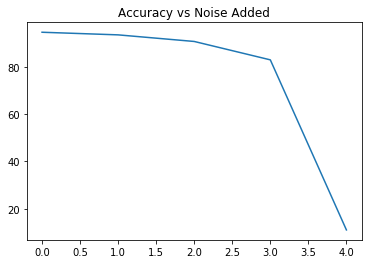

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(acc)
plt.title('Accuracy vs Noise Added')

The above plot is depicting clearly that the cnn model is robust when train with massive noisy labels. This suggest that the cnn model with noisy labels also can give us the good quality of prediction. However, still the prediction would be better if provided the clean labels. It is also observed that if the batch size is increased the model, it will perform better with noisy labels. But by changing the batch size, the learning rate also required to be changed.[1] Thus, by tuning the hyer parameters, the noisy data can also be useful in doing prediction fairly upto some extent.

**References:**  <br  \>
[1] Anon. Deep Learning is Robust to Massive Label Noise. Retrieved March 22, 2018 from https://www.bing.com/cr?IG=D63A23596755480A82433558FBB65AD8&CID=2EF48864BDD463CF274083DEBC7B62CB&rd=1&h=CEKguXIc-cfFBOvig2HqKDNNjxWViFQcwXEYSIZHFk0&v=1&r=https://arxiv.org/pdf/1705.10694.pdf&p=DevEx,5062.1